In [2]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# <center>Tarea 3 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

22 de Diciembre de 2017
</center>



# Introducción

Este trabajo tratará sobre la generación de modelos de clasificación no lineales

# 1. Small Circle inside Large Circle

El objetivo de esta sección es experimentar con algunos modelos no-lineales sobre un problema de juguete
generado para visualizar algoritmos de clustering. Se trata de un problema de clasificación a todas luces
linealmente inseparable, en el sentido que, si denotamos por $x \in \mathcal{R}^2$ un patrón de entrada y por $y \in \{0, 1\}$ su correspondiente etiqueta, no existen $w \in \mathcal{R}^2,b \in \mathcal{R}$ tal que $y(w^Tx + b) \ge \rho > 0$. El problema nos permite hacer un recorrido rápido por las grandes ideas en la búsqueda de la no linealidad.

### a. Construccion de la data e entrenamiento y prueba

In [3]:
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
    np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),
    np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [4]:
import matplotlib.pyplot as plt
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='cool')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='Greys')
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0
    axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

n_h=1
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_h, kernel_initializer='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=50, batch_size=100, verbose=1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Using TensorFlow backend.


AttributeError: module 'pandas' has no attribute 'computation'

# 2. Bike Sharing

## a) Ingreso y análisis descriptivo de los datos

In [3]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print('\nSummary - dataframe completo:\n')

print(df.describe())



Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.633839   
min        0.000000      1.000000      0.000000      0.000000      1.000000   
25%     2721.250000      2.000000      0.000000      0.000000      1.000000   
50%     5442.500000      3.000000      0.000000      1.000000      1.000000   
75%     8163.750000      4.000000      0.000000      1.000000      2.000000   
max    10885.000000      4.000000      1.000000      1.000000      4.000000   

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159    

In [4]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3


In [5]:
# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"

df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


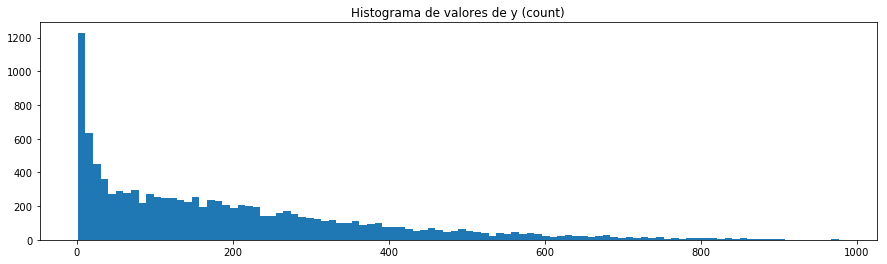

In [6]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de y (count)")
#plt.xticks(range(1,12))
plt.hist(df['count'],bins=100)
plt.show()

## b) Predicción de demanda mediante Árbol de Regresión

In [7]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL TEST =0.574239


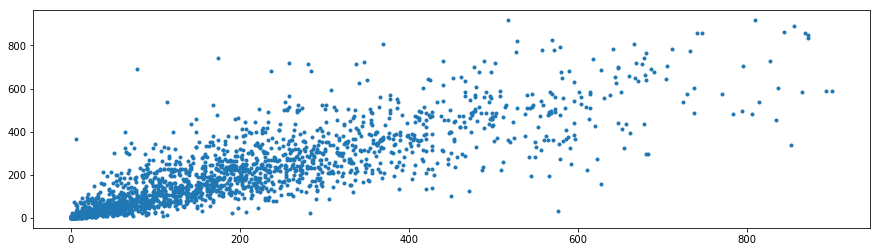

In [7]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt


Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

## c) Sintonización de parámetros para el Árbol de Regresión

In [8]:
from sklearn import grid_search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)


parameters = {'random_state' : [0], 'max_depth':range(2,30), 'min_samples_split': range(2,30), 'min_samples_leaf': range(1,30) }
clf = GridSearchCV(Tree(), parameters, scoring= make_scorer(eval_bikemodel, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = clf.best_estimator_.predict(X_val)
#Y_pred_val =
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)

/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/victor/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.711209079858
KAGG EVAL VAL =0.554511


KeyboardInterrupt: 

In [116]:
tree_model.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=12,
           min_samples_split=26, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')>

In [110]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_model, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

ModuleNotFoundError: No module named 'graphviz'

In [9]:
from sklearn import grid_search
#from sklearn.model_selection import GridSearchCV

# ARBOL POR DEFECTO
model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# ARBOL MAS MALO POSIBLE
model = Tree(max_depth= 2, min_samples_leaf= 1, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 14, min_samples_leaf= 12, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.711209079858
KAGG EVAL VAL =0.554511
0.389400784751
KAGG EVAL VAL =0.896665
0.792735149763
KAGG EVAL VAL =0.479710
0.792968373194
KAGG EVAL VAL =0.477732


## d) Preprocesamiento de los datos

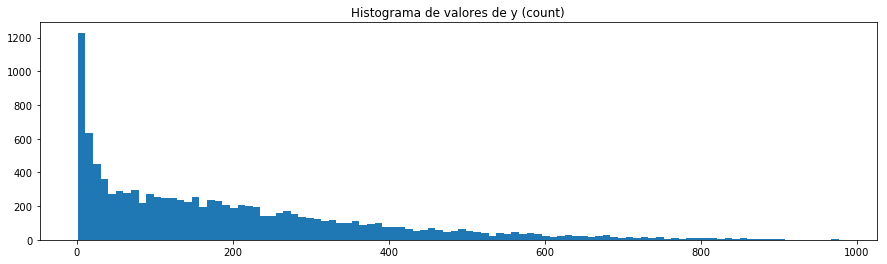

In [10]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de y (count)")
#plt.xticks(range(1,12))
plt.hist(df['count'],bins=100)
plt.show()

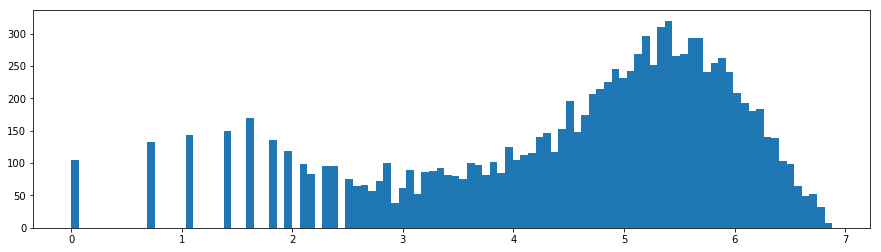

In [11]:
plt.hist((np.log(df['count'])),bins=100)
plt.show()

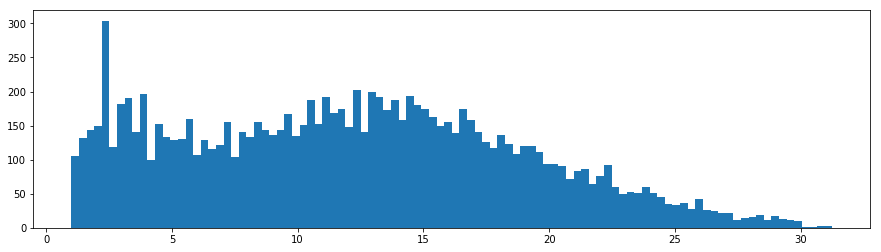

In [12]:
plt.hist((np.sqrt(df['count'])),bins=100)
plt.show()

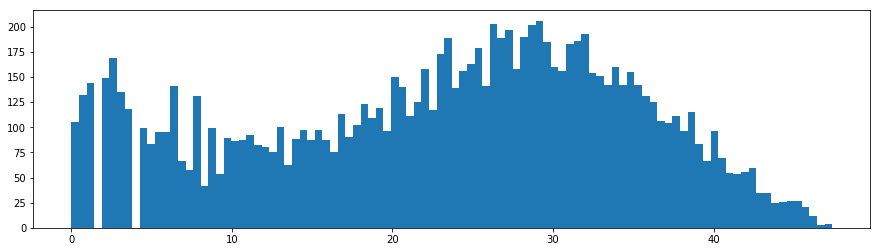

In [13]:
plt.hist((np.log(df['count'])**2),bins=100)
plt.show()

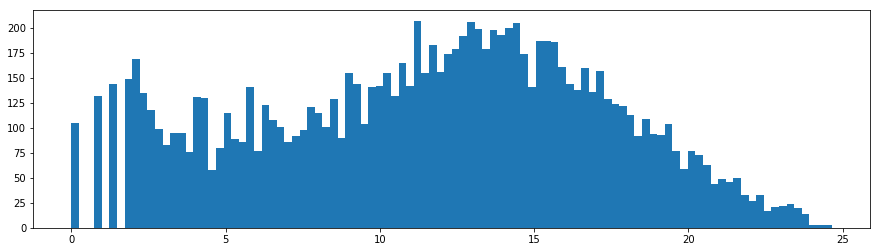

In [14]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.hist(boxcox(df['count'])[0],bins=100)
plt.show()

SCORE TEST=0.822589
KAGG EVAL TRAIN =0.010646
KAGG EVAL TEST =0.578443


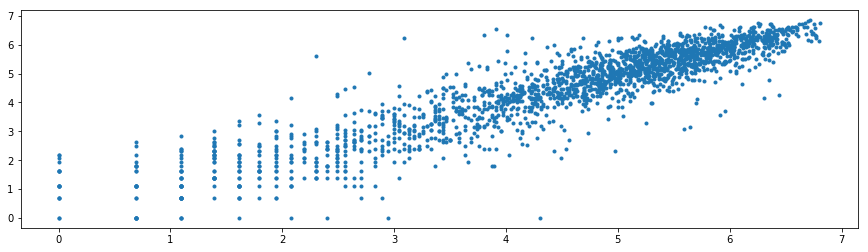

In [15]:
from sklearn.preprocessing import StandardScaler

df = pd.concat([dftrain,dfval,dftest])

# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

# Creamos una nueva columna "dias de la semana" o "cday" a partir de la columna string "datetime"
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek #0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

#print(df['cday'])

Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]
#Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
#Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]


# Aplicando logaritmo a Y, ademas hay que cambiar eval_bikemodel
#Ydf=df.loc[:,'count']


Ydf=df.loc[:,'count']
Y_std = np.log(Ydf)


#Y_std = boxcox(Ydf)[0]

#Y_std = (np.log(Ydf))**2
#Y_std = Ydf

def eval_bikemodel_log(y_predict,y_true):
    #diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    #diff = np.log(np.exp(np.sqrt(y_predict))+1.0) - np.log(np.exp(np.sqrt(y_true))+1.0)
    #diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    #diff = (inv_boxcox(y_predict)[0]+1.0) - (inv_boxcox(y_true)[0]+1.0)
    #diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    #diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Scaler_X = StandardScaler().fit(Xdf)
X_std = Scaler_X.transform(Xdf)
#Scaler_y = StandardScaler().fit(Ydf)
#Y_std = Scaler_y.transform(Ydf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]
#Y_train = Y_std[0:ntrain].values
#Y_val = Y_std[ntrain:nval].values
#Y_test = Y_std[nval:].values
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_log(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_log(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

In [29]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 14, min_samples_leaf= 12, min_samples_split= 2, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.889680362771
KAGG EVAL VAL =0.465333
0.88913694147
KAGG EVAL VAL =0.466765


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)


parameters = {'random_state' : [0], 'max_depth':range(2,30), 'min_samples_split': range(2,30), 'min_samples_leaf': range(1,30) }
clf = GridSearchCV(Tree(), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = clf.best_estimator_.predict(X_val)
#Y_pred_val =
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)

0.848826227889
KAGG EVAL VAL =0.542143
-0.637802998785 {'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 18, 'random_state': 0}
KAGG EVAL VAL =0.459117


In [31]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 3, min_samples_split= 18, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.891982477457
KAGG EVAL VAL =0.459117


## e) Predicción de Demanda mediante SVM

In [16]:
#load dataframes as before ...
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour','cday']]

# Transformacion a vectores binarios
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])

# Y
Ydf=df.loc[:,'count']
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

# X
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X_std = scalerX.fit_transform(Xdf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]


from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.302102748577
KAGG EVAL VAL =0.966316


In [17]:
# Y
Ydf=np.log(df.loc[:,'count'])
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.916631380463
KAGG EVAL VAL =0.399695


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

#parameters = {'C':range(1,10), 'epsilon': [0.1, 0.3, 0.5, 0.7, 1, 1.3], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
parameters = {'C':range(1,5), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }
clf = GridSearchCV(SVR(), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False))
clf.fit(X_train,Y_train)
svm_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = clf.best_estimator_.predict(X_val)
#Y_pred_val =
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)

KeyboardInterrupt: 